In [1]:
!pip install -q kaggle timm h5py torchmetrics tqdm seaborn matplotlib scikit-learn torchinfo

import os
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassAUROC,
    MulticlassMatthewsCorrCoef
)

from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 32.4 MB/s eta 0:00:00
Using device: cuda


In [2]:
KAGGLE_USERNAME = "YOUR_USERNAME"
KAGGLE_KEY = "YOUR_KEY"

os.makedirs("/root/.config/kaggle", exist_ok=True)
with open("/root/.config/kaggle/kaggle.json", "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
os.chmod("/root/.config/kaggle/kaggle.json", 0o600)

from kaggle.api.kaggle_api_extended import KaggleApi

DATA_DIR = "brain_tumor_dataset"
DATASET = "ashkhagan/figshare-brain-tumor-dataset"

if not os.path.exists(DATA_DIR):
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(DATASET, path=DATA_DIR, unzip=True)


Dataset URL: https://www.kaggle.com/datasets/ashkhagan/figshare-brain-tumor-dataset


In [3]:
mat_files = []
for root, _, files in os.walk(DATA_DIR):
    for f in files:
        if f.endswith(".mat") and "cvind" not in f.lower():
            mat_files.append(os.path.join(root, f))

paths, labels = [], []

for f in mat_files:
    with h5py.File(f, "r") as mat:
        if "label" in mat:
            label = int(mat["label"][()][0][0])
        else:
            label = int(mat["cjdata"]["label"][()][0][0])
    paths.append(f)
    labels.append(label - 1)

df = pd.DataFrame({"image_path": paths, "label": labels})
num_classes = df["label"].nunique()

train_df, test_df = train_test_split(df, stratify=df.label, test_size=0.2, random_state=42)
train_df, val_df  = train_test_split(train_df, stratify=train_df.label, test_size=0.2, random_state=42)


In [4]:
class BrainTumorDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "image_path"]
        label = self.df.loc[idx, "label"]

        with h5py.File(path, "r") as mat:
            if "image" in mat:
                img = mat["image"][()]
            else:
                img = mat["cjdata"]["image"][()]

        img = np.array(img).T
        img = np.stack([img]*3, axis=-1).astype(np.uint8)
        img = self.transform(img)

        return img, label


In [5]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),
                         (0.229,0.224,0.225))
])

train_loader = DataLoader(BrainTumorDataset(train_df, transform), batch_size=8, shuffle=True)
val_loader   = DataLoader(BrainTumorDataset(val_df, transform), batch_size=8)
test_loader  = DataLoader(BrainTumorDataset(test_df, transform), batch_size=8)


In [6]:
model = timm.create_model(
    "resnet50",
    pretrained=True
)

model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

summary(model, input_size=(1,3,224,224))


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 3]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─Identity: 3-6                [1, 64, 56, 56]           --
│ 

In [7]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-4
)

EPOCHS = 30
patience = 5

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS
)


In [8]:
def get_metrics():
    return {
        "acc": MulticlassAccuracy(num_classes=num_classes).to(device),
        "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
        "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
        "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
        "auc": MulticlassAUROC(num_classes=num_classes).to(device),
        "mcc": MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
    }

def multiclass_specificity_sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    spec, sens = [], []

    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        tn = cm.sum() - (tp+fp+fn)

        spec.append(tn/(tn+fp+1e-8))
        sens.append(tp/(tp+fn+1e-8))

    return float(np.mean(spec)), float(np.mean(sens))


In [9]:
history = {
    "loss": [], "val_loss": [],
    "accuracy": [], "val_accuracy": [],
    "precision": [], "val_precision": [],
    "recall": [], "val_recall": [],
    "f1": [], "val_f1": [],
    "specificity": [], "val_specificity": [],
    "sensitivity": [], "val_sensitivity": [],
    "mcc": [], "val_mcc": [],
    "auc": [], "val_auc": []
}

best_val_loss = float("inf")
counter = 0

for epoch in range(EPOCHS):

    # ===================== TRAIN =====================
    model.train()
    train_loss = 0
    train_preds, train_targets = [], []
    train_metrics = get_metrics()

    pbar = tqdm(train_loader, desc=f"Training Model - Epoch [{epoch+1}/{EPOCHS}]")

    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = out.argmax(1)

        train_preds.append(preds.cpu())
        train_targets.append(y.cpu())

        for m in train_metrics.values():
            m.update(out, y)

    train_loss /= len(train_loader)

    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()

    train_spec, train_sens = multiclass_specificity_sensitivity(train_targets, train_preds)
    train_out = {k: v.compute().item() for k, v in train_metrics.items()}

    print(f"\n[TRAIN] loss: {train_loss:.4f}, accuracy: {train_out['acc']:.4f}, "
          f"precision: {train_out['precision']:.4f}, recall: {train_out['recall']:.4f}, "
          f"f1_score: {train_out['f1']:.4f}, specificity: {train_spec:.4f}, "
          f"sensitivity: {train_sens:.4f}, mcc: {train_out['mcc']:.4f}, "
          f"auc: {train_out['auc']:.4f}")

    # ===================== VALIDATION =====================
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []
    val_metrics = get_metrics()

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Validating Model"):
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()

            preds = out.argmax(1)
            val_preds.append(preds.cpu())
            val_targets.append(y.cpu())

            for m in val_metrics.values():
                m.update(out, y)

    val_loss /= len(val_loader)

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()

    val_spec, val_sens = multiclass_specificity_sensitivity(val_targets, val_preds)
    val_out = {k: v.compute().item() for k, v in val_metrics.items()}

    print(f"[VAL]   loss: {val_loss:.4f}, accuracy: {val_out['acc']:.4f}, "
          f"precision: {val_out['precision']:.4f}, recall: {val_out['recall']:.4f}, "
          f"f1_score: {val_out['f1']:.4f}, specificity: {val_spec:.4f}, "
          f"sensitivity: {val_sens:.4f}, mcc: {val_out['mcc']:.4f}, "
          f"auc: {val_out['auc']:.4f}")

    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6e}\n")

    # ===================== SAVE HISTORY =====================
    history["loss"].append(train_loss)
    history["accuracy"].append(train_out["acc"])
    history["precision"].append(train_out["precision"])
    history["recall"].append(train_out["recall"])
    history["f1"].append(train_out["f1"])
    history["specificity"].append(train_spec)
    history["sensitivity"].append(train_sens)
    history["mcc"].append(train_out["mcc"])
    history["auc"].append(train_out["auc"])

    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_out["acc"])
    history["val_precision"].append(val_out["precision"])
    history["val_recall"].append(val_out["recall"])
    history["val_f1"].append(val_out["f1"])
    history["val_specificity"].append(val_spec)
    history["val_sensitivity"].append(val_sens)
    history["val_mcc"].append(val_out["mcc"])
    history["val_auc"].append(val_out["auc"])

    # ===================== LR SCHEDULER =====================
    scheduler.step()

    # ===================== EARLY STOPPING =====================
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Training Model - Epoch [1/30]: 100%|██████████| 245/245 [00:49<00:00,  4.91it/s]



[TRAIN] loss: 0.5615, accuracy: 0.7340, precision: 0.7523, recall: 0.7340, f1_score: 0.7400, specificity: 0.8752, sensitivity: 0.7340, mcc: 0.6301, auc: 0.9135


Validating Model: 100%|██████████| 62/62 [00:08<00:00,  7.56it/s]


[VAL]   loss: 0.3237, accuracy: 0.8899, precision: 0.8663, recall: 0.8899, f1_score: 0.8728, specificity: 0.9449, sensitivity: 0.8899, mcc: 0.8214, auc: 0.9667
Current LR: 5.000000e-04



Training Model - Epoch [2/30]: 100%|██████████| 245/245 [00:45<00:00,  5.35it/s]



[TRAIN] loss: 0.2953, accuracy: 0.8773, precision: 0.8623, recall: 0.8773, f1_score: 0.8681, specificity: 0.9417, sensitivity: 0.8773, mcc: 0.8141, auc: 0.9701


Validating Model: 100%|██████████| 62/62 [00:08<00:00,  7.35it/s]


[VAL]   loss: 0.5472, accuracy: 0.8382, precision: 0.8510, recall: 0.8382, f1_score: 0.8435, specificity: 0.9195, sensitivity: 0.8382, mcc: 0.7660, auc: 0.9402
Current LR: 4.986305e-04



Training Model - Epoch [3/30]: 100%|██████████| 245/245 [00:45<00:00,  5.43it/s]



[TRAIN] loss: 0.1885, accuracy: 0.9247, precision: 0.9171, recall: 0.9247, f1_score: 0.9206, specificity: 0.9640, sensitivity: 0.9247, mcc: 0.8873, auc: 0.9870


Validating Model: 100%|██████████| 62/62 [00:08<00:00,  7.74it/s]


[VAL]   loss: 0.3851, accuracy: 0.8910, precision: 0.8765, recall: 0.8910, f1_score: 0.8777, specificity: 0.9410, sensitivity: 0.8910, mcc: 0.8189, auc: 0.9697
Current LR: 4.945369e-04



Training Model - Epoch [4/30]: 100%|██████████| 245/245 [00:45<00:00,  5.40it/s]



[TRAIN] loss: 0.0924, accuracy: 0.9721, precision: 0.9680, recall: 0.9721, f1_score: 0.9700, specificity: 0.9863, sensitivity: 0.9721, mcc: 0.9570, auc: 0.9966


Validating Model: 100%|██████████| 62/62 [00:08<00:00,  7.44it/s]


[VAL]   loss: 0.1890, accuracy: 0.9337, precision: 0.9315, recall: 0.9337, f1_score: 0.9325, specificity: 0.9690, sensitivity: 0.9337, mcc: 0.9044, auc: 0.9876
Current LR: 4.877641e-04



Training Model - Epoch [5/30]: 100%|██████████| 245/245 [00:46<00:00,  5.31it/s]



[TRAIN] loss: 0.0763, accuracy: 0.9724, precision: 0.9730, recall: 0.9724, f1_score: 0.9727, specificity: 0.9870, sensitivity: 0.9724, mcc: 0.9608, auc: 0.9980


Validating Model: 100%|██████████| 62/62 [00:07<00:00,  8.02it/s]


[VAL]   loss: 0.3051, accuracy: 0.9249, precision: 0.9132, recall: 0.9249, f1_score: 0.9180, specificity: 0.9619, sensitivity: 0.9249, mcc: 0.8804, auc: 0.9778
Current LR: 4.783864e-04



Training Model - Epoch [6/30]: 100%|██████████| 245/245 [00:45<00:00,  5.38it/s]



[TRAIN] loss: 0.0691, accuracy: 0.9776, precision: 0.9749, recall: 0.9776, f1_score: 0.9762, specificity: 0.9895, sensitivity: 0.9776, mcc: 0.9665, auc: 0.9981


Validating Model: 100%|██████████| 62/62 [00:08<00:00,  7.27it/s]


[VAL]   loss: 0.2328, accuracy: 0.9220, precision: 0.9202, recall: 0.9220, f1_score: 0.9210, specificity: 0.9637, sensitivity: 0.9220, mcc: 0.8884, auc: 0.9854
Current LR: 4.665064e-04



Training Model - Epoch [7/30]: 100%|██████████| 245/245 [00:47<00:00,  5.20it/s]



[TRAIN] loss: 0.0442, accuracy: 0.9853, precision: 0.9844, recall: 0.9853, f1_score: 0.9849, specificity: 0.9929, sensitivity: 0.9853, mcc: 0.9784, auc: 0.9990


Validating Model: 100%|██████████| 62/62 [00:07<00:00,  7.76it/s]


[VAL]   loss: 0.3119, accuracy: 0.8275, precision: 0.8829, recall: 0.8275, f1_score: 0.8397, specificity: 0.9254, sensitivity: 0.8275, mcc: 0.8025, auc: 0.9808
Current LR: 4.522542e-04



Training Model - Epoch [8/30]: 100%|██████████| 245/245 [00:46<00:00,  5.32it/s]



[TRAIN] loss: 0.0290, accuracy: 0.9913, precision: 0.9901, recall: 0.9913, f1_score: 0.9907, specificity: 0.9960, sensitivity: 0.9913, mcc: 0.9872, auc: 0.9997


Validating Model: 100%|██████████| 62/62 [00:08<00:00,  7.46it/s]


[VAL]   loss: 0.1868, accuracy: 0.9287, precision: 0.9271, recall: 0.9287, f1_score: 0.9277, specificity: 0.9684, sensitivity: 0.9287, mcc: 0.9013, auc: 0.9907
Current LR: 4.357862e-04



Training Model - Epoch [9/30]: 100%|██████████| 245/245 [00:46<00:00,  5.31it/s]



[TRAIN] loss: 0.0115, accuracy: 0.9967, precision: 0.9965, recall: 0.9967, f1_score: 0.9966, specificity: 0.9985, sensitivity: 0.9967, mcc: 0.9952, auc: 0.9999


Validating Model: 100%|██████████| 62/62 [00:07<00:00,  7.92it/s]


[VAL]   loss: 0.2024, accuracy: 0.9368, precision: 0.9315, recall: 0.9368, f1_score: 0.9340, specificity: 0.9707, sensitivity: 0.9368, mcc: 0.9078, auc: 0.9889
Current LR: 4.172827e-04



Training Model - Epoch [10/30]: 100%|██████████| 245/245 [00:45<00:00,  5.36it/s]



[TRAIN] loss: 0.0210, accuracy: 0.9924, precision: 0.9919, recall: 0.9924, f1_score: 0.9922, specificity: 0.9969, sensitivity: 0.9924, mcc: 0.9896, auc: 0.9997


Validating Model: 100%|██████████| 62/62 [00:08<00:00,  7.43it/s]


[VAL]   loss: 0.2042, accuracy: 0.9249, precision: 0.9320, recall: 0.9249, f1_score: 0.9280, specificity: 0.9666, sensitivity: 0.9249, mcc: 0.9008, auc: 0.9897
Current LR: 3.969463e-04



Training Model - Epoch [11/30]: 100%|██████████| 245/245 [00:45<00:00,  5.33it/s]



[TRAIN] loss: 0.0143, accuracy: 0.9938, precision: 0.9939, recall: 0.9938, f1_score: 0.9938, specificity: 0.9971, sensitivity: 0.9938, mcc: 0.9912, auc: 0.9999


Validating Model: 100%|██████████| 62/62 [00:07<00:00,  8.12it/s]


[VAL]   loss: 0.2305, accuracy: 0.9181, precision: 0.9264, recall: 0.9181, f1_score: 0.9219, specificity: 0.9634, sensitivity: 0.9181, mcc: 0.8911, auc: 0.9898
Current LR: 3.750000e-04



Training Model - Epoch [12/30]: 100%|██████████| 245/245 [00:46<00:00,  5.30it/s]



[TRAIN] loss: 0.0073, accuracy: 0.9972, precision: 0.9976, recall: 0.9972, f1_score: 0.9974, specificity: 0.9986, sensitivity: 0.9972, mcc: 0.9960, auc: 1.0000


Validating Model: 100%|██████████| 62/62 [00:08<00:00,  7.32it/s]


[VAL]   loss: 0.2918, accuracy: 0.8884, precision: 0.8903, recall: 0.8884, f1_score: 0.8890, specificity: 0.9523, sensitivity: 0.8884, mcc: 0.8499, auc: 0.9847
Current LR: 3.516842e-04



Training Model - Epoch [13/30]: 100%|██████████| 245/245 [00:46<00:00,  5.30it/s]



[TRAIN] loss: 0.0156, accuracy: 0.9943, precision: 0.9939, recall: 0.9943, f1_score: 0.9941, specificity: 0.9971, sensitivity: 0.9943, mcc: 0.9912, auc: 0.9999


Validating Model: 100%|██████████| 62/62 [00:07<00:00,  7.97it/s]

[VAL]   loss: 0.2175, accuracy: 0.9315, precision: 0.9274, recall: 0.9315, f1_score: 0.9294, specificity: 0.9686, sensitivity: 0.9315, mcc: 0.9013, auc: 0.9885
Current LR: 3.272542e-04

Early stopping triggered.


In [10]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [11]:
test_metrics = get_metrics()
test_loss = 0
all_preds, all_targets = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)
        test_loss += loss.item()

        preds = out.argmax(1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

        for m in test_metrics.values():
            m.update(out, y)

test_loss /= len(test_loader)

print("\n===== TEST RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")

for k, v in test_metrics.items():
    print(f"{k.upper()}: {v.compute().item():.4f}")


Testing: 100%|██████████| 77/77 [00:10<00:00,  7.40it/s]


===== TEST RESULTS =====
Test Loss: 0.2467
ACC: 0.9208
PRECISION: 0.9134
RECALL: 0.9208
F1: 0.9167
AUC: 0.9880
MCC: 0.8835


In [12]:
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

print("\n===== CLASSIFICATION REPORT =====\n")
print(classification_report(all_targets, all_preds, digits=4))



===== CLASSIFICATION REPORT =====

              precision    recall  f1-score   support

           0     0.8403    0.8521    0.8462       142
           1     0.9560    0.9158    0.9355       285
           2     0.9439    0.9946    0.9686       186

    accuracy                         0.9250       613
   macro avg     0.9134    0.9208    0.9167       613
weighted avg     0.9255    0.9250    0.9248       613



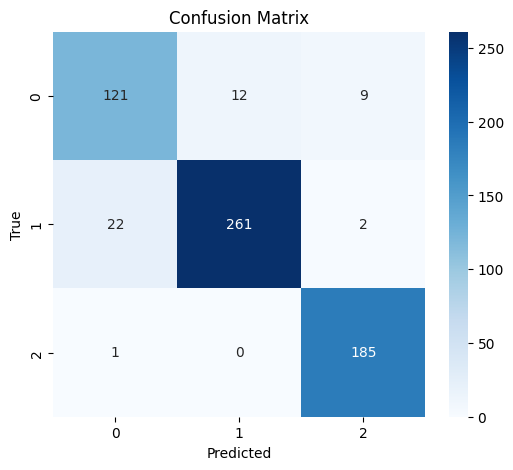

In [13]:
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [14]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


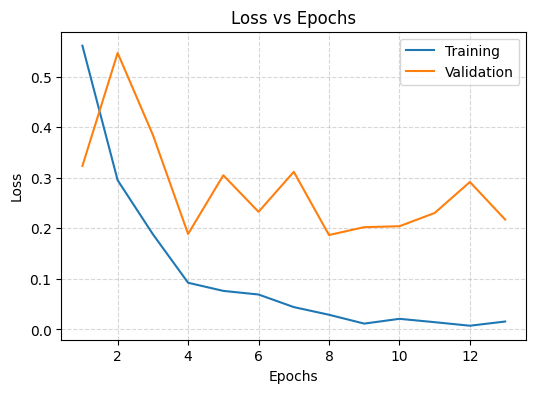

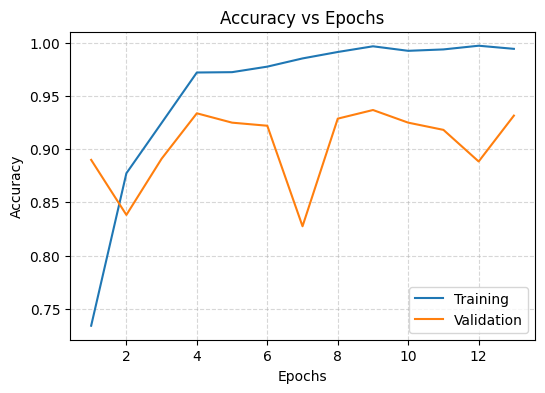

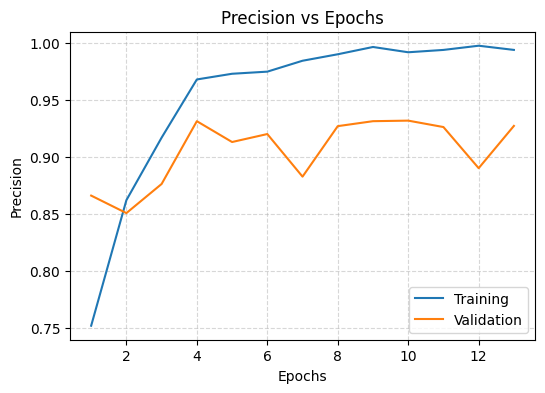

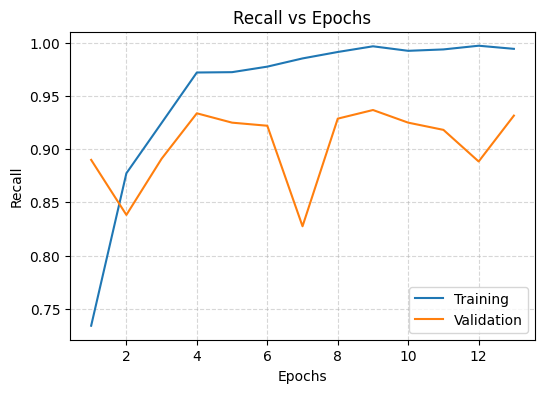

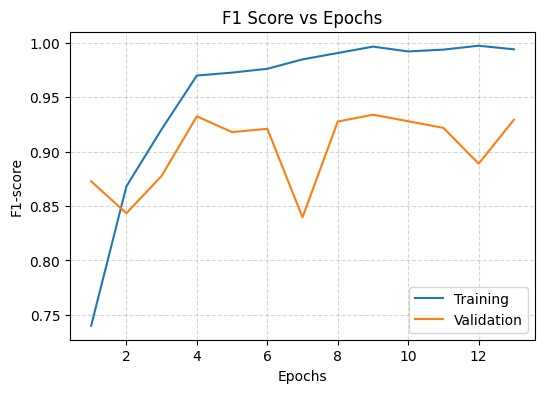

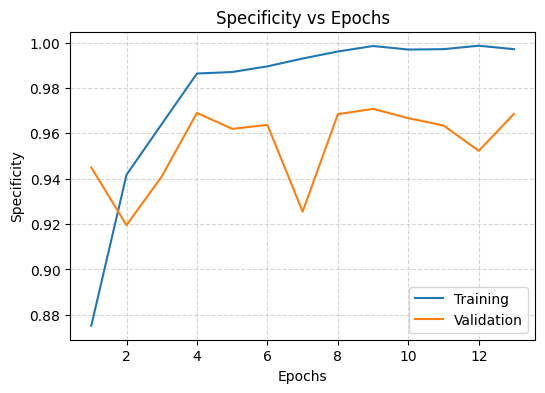

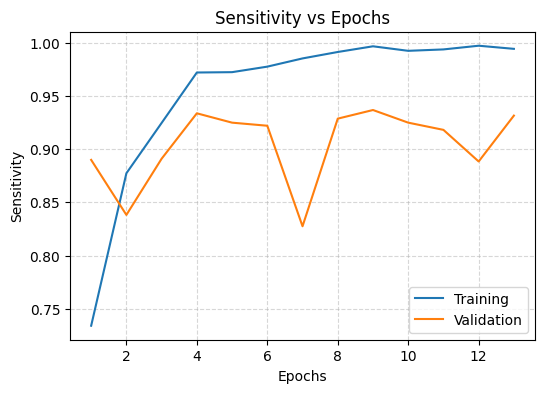

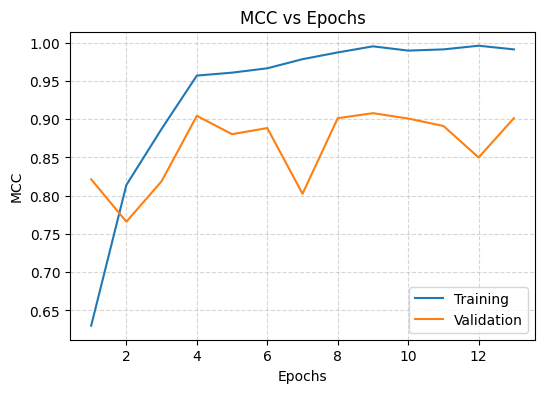

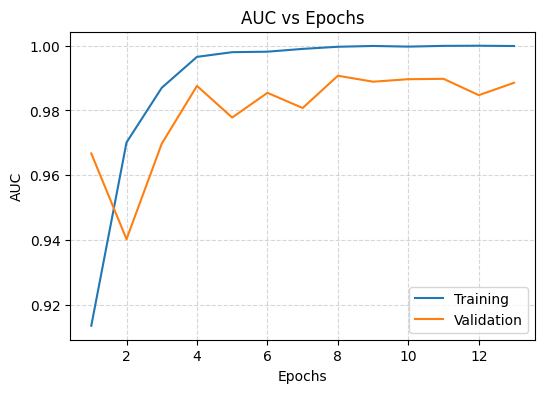

In [15]:
plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1 Score vs Epochs", "F1-score")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")
